# Sentinel-2 Field Parcel Extraction

## Learning Objectives

In this notebook you will learn how to

* rasterize vector features
* extract agricultural field parcels with a specific crop type from a Sentinel-2 scene
* export the pixels of a specific crop type to a GeoPandas GeoDataFrame

## Tutorial Content

This tutorial is introductorial level. Basic knowledge about [GeoPandas](https://geopandas.org/en/stable/) might be helpful.

To run this notebook no additional requirements in terms of software-setup are necessary.

The data required to run this notebook can be found [here](./../data).

In [9]:
# load required modules
import cv2
import numpy as np
import geopandas as gpd

from pathlib import Path
from agrisatpy.io.sentinel2 import Sentinel2Handler

# make plots larger by default
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

We use a Sentinel-2 scene acquired over southern Bavaria in 2019 and some field parcels that were manually delimited and labelled with three different crop types.

In [3]:
# download test data (if not done yet)
import requests
from agrisatpy.downloader.sentinel2.utils import unzip_datasets

# URL to the public dataset
url = 'https://data.mendeley.com/public-files/datasets/ckcxh6jskz/files/e97b9543-b8d8-436e-b967-7e64fe7be62c/file_downloaded'

testdata_dir = Path('../data')
testdata_fname = testdata_dir.joinpath('S2A_MSIL2A_20190524T101031_N0212_R022_T32UPU_20190524T130304.zip')
testdata_fname_unzipped = Path(testdata_fname.as_posix().replace('.zip', '.SAFE'))

# check first if the dataset has been already downloaded; only start the download if the dataset is not yet available locally
if not testdata_fname_unzipped.exists():

    # download dataset
    r = requests.get(url, stream=True)
    r.raise_for_status()
    with open(testdata_fname, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=5096):
            fd.write(chunk)

    # unzip dataset
    unzip_datasets(download_dir=testdata_dir)

Open the Sentinel-2 dataset (all 10 and 20m bands plus the scene classification layer) for the bounding box in which all of the field parcels are located.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


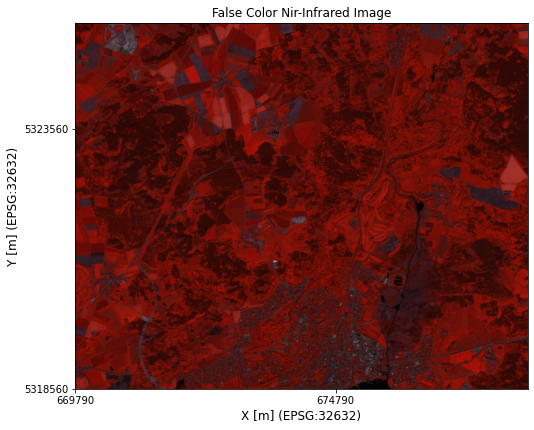

In [7]:
# define file-path to ESRI shapefile (all formats understood by fiona work)
field_parcels = Path('../data/sample_polygons/BY_Polygons_Canola_2019_EPSG32632.shp')

# read data from .SAFE dataset for the selected AOI and spectral bands
handler = Sentinel2Handler()
handler.read_from_safe(
    in_dir=testdata_fname_unzipped,
    polygon_features=field_parcels,
    full_bounding_box_only=True
)

fig_nir = handler.plot_false_color_infrared()

The parcel polygons are vector features (ESRI shapefile). We can open them using GeoPandas:

In [10]:
parcels_gdf = gpd.read_file(field_parcels)
parcels_gdf.head()

,id,crop_code,crop_type,geometry
0,1,1,Canola,"POLYGON ((11.28091 48.00947, 11.28463 48.00837..."
1,2,1,Canola,"POLYGON ((11.27627 47.99920, 11.27718 47.99970..."
2,3,1,Canola,"POLYGON ((11.31743 48.01035, 11.31907 48.01035..."
3,4,1,Canola,"POLYGON ((11.39011 48.03560, 11.39414 48.03179..."
4,5,1,Canola,"POLYGON ((11.31546 48.04705, 11.31665 48.04720..."


<AxesSubplot:>

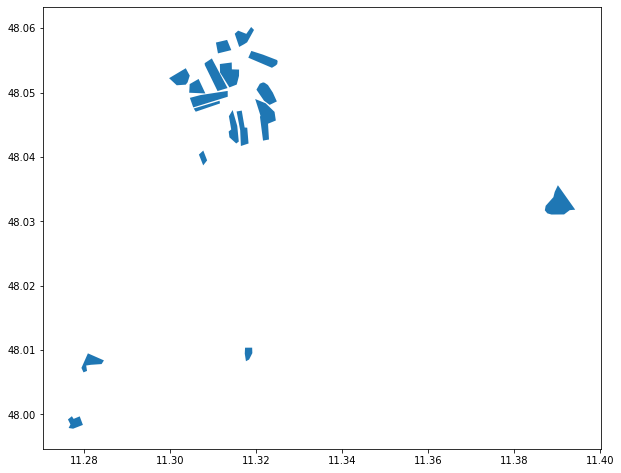

In [11]:
parcels_gdf.plot()

We can rasterize the `crop_code` attribute and add it as a new band to the `handler` object. To do so, *AgriSatPy* requires the specification of a `snap` band that specifies the spatial resolution and extent of the rasterized vector features.

In [14]:
handler.add_bands_from_vector(
    in_file_vector=field_parcels,         
    snap_band='blue',                   # we use one of the 10m bands
    attribute_selection=['crop_code'],  # we can use any selection of numeric attributes; each attribute becomes a new raster band
    blackfill_value=0                   # here it is important to choose a value that not occurs in the data to rasterize
)

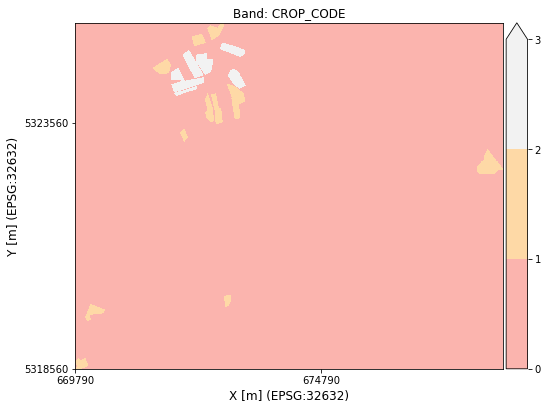

In [17]:
fig_cc = handler.plot_band('crop_code', colormap='Pastel1', discrete_values=True)

Now we can mask all pixels not labelled as canola (crop code == 1). Since all to mask must have the same spatial resolution (10m) we have to resample the 20m bands to 10m first.

In [20]:
# resample to 10m first
handler.resample(
    target_resolution=10,   # meter
    resampling_method=cv2.INTER_NEAREST_EXACT
)

bands_to_mask = handler.get_bandnames()

handler.mask(
    name_mask_band='crop_code',
    mask_values=[1],  # 1 is the code for canola
    bands_to_mask=bands_to_mask,
    keep_mask_values=True  # we want to keep all canola pixels
)

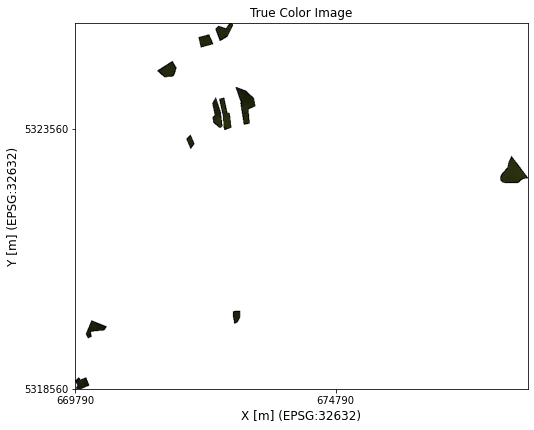

In [22]:
fig_rgb_canola = handler.plot_rgb()

Finally, we can convert the raster data into a GeoPandas GeoDataFrame to apply further data analysis:

In [23]:
gdf_canola_pixels = handler.to_dataframe()

TypeError: Object of type CRS is not JSON serializable